In [1]:
from __future__ import division
import copy
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt 
from tabulate import tabulate
import operator
from sklearn.metrics import mean_absolute_error
import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape,  Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse

Using TensorFlow backend.


# **Part A - Data Analysis**

# Exercise 1

In [0]:
# Load train and test
cols = ['user_id','item_id','rating','timestamp']
train = pd.read_csv('u1.base',delimiter='\t',names=cols,encoding='latin-1')
test = pd.read_csv('u1.test',delimiter='\t',names=cols,encoding='latin-1')

In [0]:
# calculate average ratings
averages = train[['item_id','rating']].groupby('item_id').mean()

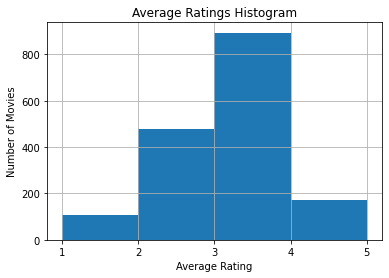

In [29]:
# Show histograms for averages
hist1 = averages.hist(bins=4)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Average Ratings Histogram')
plt.xticks([1,2,3,4,5])
plt.show()

In [31]:
# Show top 3 movies with highest average ranks
averages.nlargest(3, columns="rating")

,rating
item_id,
1122,5.0
1189,5.0
1201,5.0


In [0]:
# Load users
cols2 = ['user_id','age','gender','occupation','zip']
users = pd.read_csv('u.user',delimiter='|',names=cols2,encoding='latin-1')
users_join = users.merge(train, how='inner')

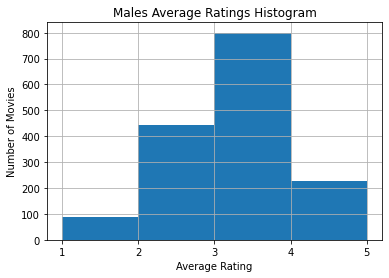

In [34]:
# Show histograms for males averages
males = users_join[users_join['gender'] == 'M']
males_averages = males[['item_id','rating']].groupby('item_id').mean()
hist_male = males_averages.hist(bins=4)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Males Average Ratings Histogram')
plt.xticks([1,2,3,4,5])
plt.show()

In [35]:
# Show top 3 movies with highest average ranks for males
males_averages.nlargest(3, columns="rating")

,rating
item_id,
1122,5.0
1144,5.0
1175,5.0


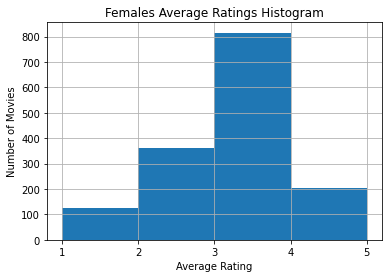

In [37]:
# Show averages for females
females = users_join[users_join['gender'] == 'F']
females_averages = females[['item_id','rating']].groupby('item_id').mean()
# hist_female = females_averages.hist()
hist_female = females_averages.hist(bins=4)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Females Average Ratings Histogram')
plt.xticks([1,2,3,4,5])
plt.show()


In [0]:
# Show top 3 movies with highest average ranks for females
females_averages.nlargest(3, columns="rating")

,rating
item_id,
74,5.0
838,5.0
891,5.0


In [0]:
# Top 3 movies with highest difference between males and females
males_and_females = pd.merge(males_averages, females_averages, on = 'item_id', how = 'inner')
males_and_females['difference'] = (males_and_females['rating_x'] - males_and_females['rating_y']).abs()
males_and_females.nlargest(3, columns="difference")[['difference']]

,difference
item_id,
1175,4.000000
851,3.666667
1429,3.500000


In [0]:
# Load movies and ratings and join them
cols3 = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
movies = pd.read_csv('u.item',delimiter='|',names=cols3,encoding='latin-1')
ratings = pd.read_csv('u.data',delimiter='\t',names=cols,encoding='latin-1')
movies_and_ratings = ratings.join(movies.set_index('movie_id'), on='item_id')



In [0]:
# Split movies to high-rated and low-rated based on total average
total_average = movies_and_ratings['rating'].mean()
high = movies_and_ratings.loc[movies_and_ratings['rating'] >= total_average]
low = movies_and_ratings.loc[movies_and_ratings['rating'] < total_average]

In [0]:
# check frequency of genres for high and low rated movies

genres = ['unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

high_genres = {}
low_genres = {}

for genre in genres:
    genre_high_movies = high[genre] == 1
    genre_low_movies = low[genre] == 1
    high_genres[genre] = high[genre_high_movies].shape[0]
    low_genres[genre] = low[genre_low_movies].shape[0]

# sort from high to low
high_genres = sorted(high_genres.items(), key=operator.itemgetter(1),reverse=True)
low_genres = sorted(low_genres.items(), key=operator.itemgetter(1),reverse=True)

In [0]:
# this function creates histogram

def histogram(genres_count, title):
  fig = plt.figure(1, figsize=(12,10))
  ax2 = fig.add_subplot(2,1,2)
  y_axis = [genre[1] for genre in genres_count]
  x_axis = [i for i in range(len(genres_count))]
  x_label = [genre[0] for genre in genres_count]
  plt.xticks(rotation = 50, fontsize = 10)
  plt.yticks(fontsize = 10)
  plt.xticks(x_axis, x_label)
  plt.ylabel("Occurences", fontsize = 20, labelpad = 5)
  ax2.bar(x_axis, y_axis, align = 'center', color='b')
  plt.title(title,color='black',fontsize = 24)
  plt.show()

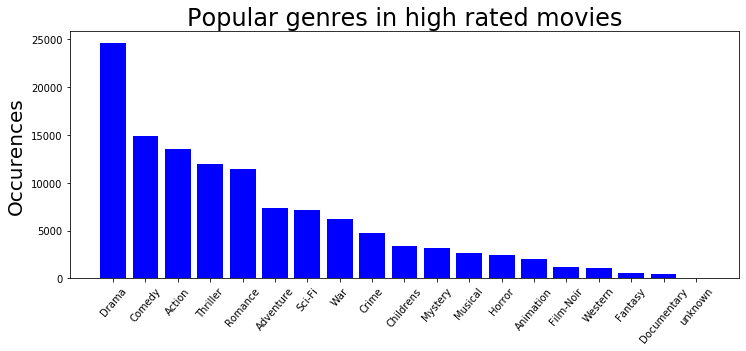

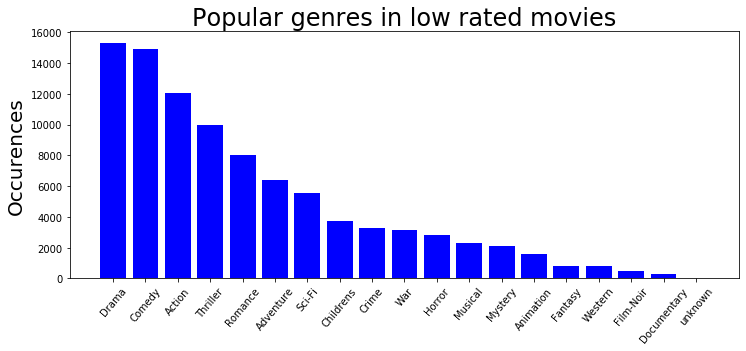

In [0]:
histogram(high_genres, "Popular genres in high rated movies")
histogram(low_genres, "Popular genres in low rated movies")

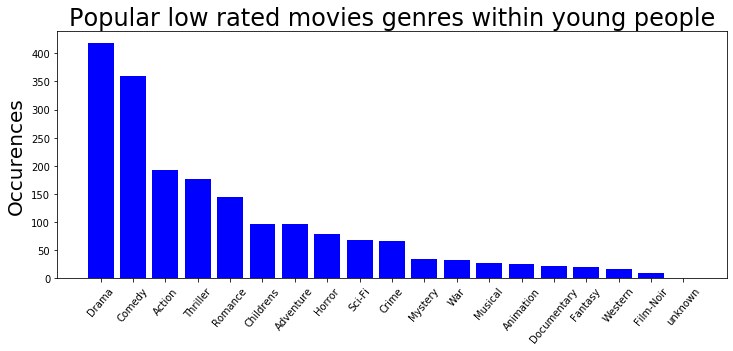

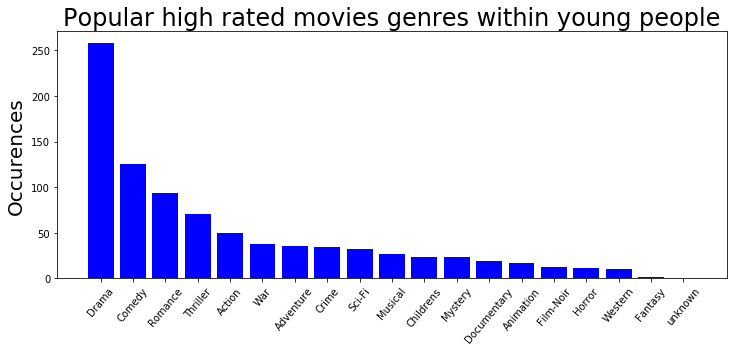

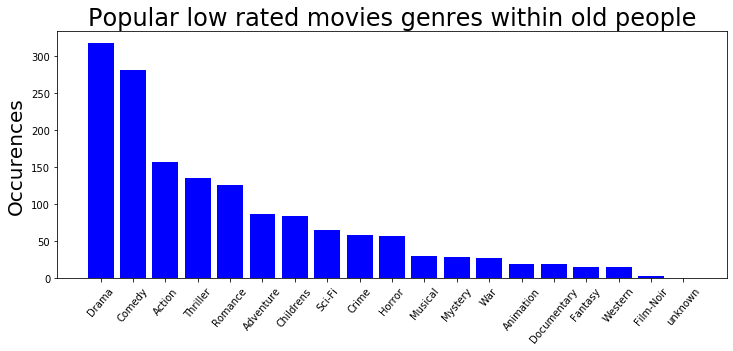

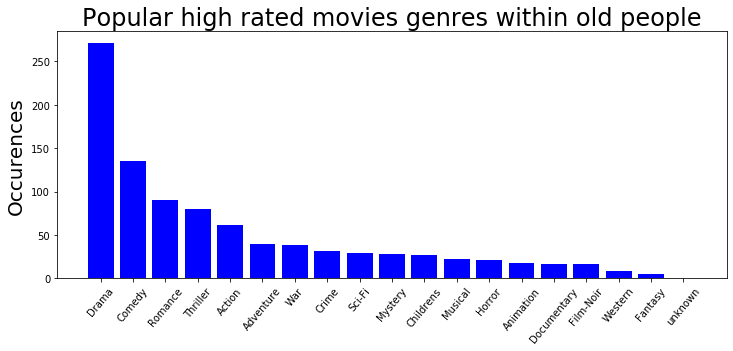

In [0]:
# check frequency of genres within young and old people

groups = [(users_join['age'] <= 40), (users_join['age'] >= 41)]
meaning = ['young','old']
users_join['age_type'] = np.select(groups, meaning)
young = users_join[users_join['age_type'] == "young"]
old = users_join[users_join['age_type'] == "old"]

young_mean = young[['item_id','rating']].groupby('item_id').agg('mean')
old_mean = old[['item_id','rating']].groupby('item_id').agg('mean')
young_movies = movies.merge(young_mean, left_on = 'movie_id', right_on = 'item_id', how = 'inner')
old_movies = movies.merge(old_mean, left_on = 'movie_id', right_on = 'item_id', how = 'inner')

young_low = young_movies[young_movies['rating'] < total_average]
old_low = old_movies[old_movies['rating'] < total_average]
young_high = young_movies[young_movies['rating'] >= total_average]
old_high = old_movies[old_movies['rating'] >= total_average]

young_low_genres = {}
young_high_genres = {}
old_low_genres = {}
old_high_genres = {}

for genre in genres:

    genre_young_low_movies = young_low[genre] == 1
    genre_young_high_movies = young_high[genre] == 1

    genre_old_low_movies = old_low[genre] == 1
    genre_old_high_movies = old_high[genre] == 1

    young_low_genres[genre] = young_low[genre_young_low_movies].shape[0]
    young_high_genres[genre] = young_high[genre_young_high_movies].shape[0]

    old_low_genres[genre] = old_low[genre_old_low_movies].shape[0]
    old_high_genres[genre] = old_high[genre_old_high_movies].shape[0]

# sort from high to low
young_low_genres = sorted(young_low_genres.items(), key=operator.itemgetter(1), reverse=True)
young_high_genres = sorted(young_high_genres.items(), key=operator.itemgetter(1), reverse=True)
old_low_genres = sorted(old_low_genres.items(), key=operator.itemgetter(1), reverse=True)
old_high_genres = sorted(old_high_genres.items(), key=operator.itemgetter(1), reverse=True)

# show histograms for each
histogram(young_low_genres, "Popular low rated movies genres within young people")
histogram(young_high_genres, "Popular high rated movies genres within young people")
histogram(old_low_genres, "Popular low rated movies genres within old people")
histogram(old_high_genres, "Popular high rated movies genres within old people")

In [0]:
# find most popular movies by the amount of time they were ranked

movies_ratings_count = {}
for index, row in ratings.iterrows():
  item_id = row['item_id'];
  if movies_ratings_count.get(item_id) is None:
    movies_ratings_count[item_id] = 0
  movies_ratings_count[item_id] += 1

movies_ratings_count = sorted(movies_ratings_count.items(), key=operator.itemgetter(1),reverse=True)

In [0]:
# show results

df = pd.DataFrame(movies_ratings_count, columns=["movie_id", "# times ranked"])
df.nlargest(5, "# times ranked")


,movie_id,# times ranked
0,50,583
1,258,509
2,100,508
3,181,507
4,294,485


# **Part B - Non-Personal Recommendations**

# Exercise 2

In [0]:
# calculate mae
def calc_mae(df):
  sum = 0
  for index, row in df.iterrows():
    average = row['rating_x']
    real = row['rating_y']
    sum = sum + abs(average-real)
  mae = sum/df.shape[0]
  return mae

# get user movies
def get_movies(df):
  users_movies = {}
  for index, row in df.iterrows():
    if users_movies.get(row['user_id']) is None:
      users_movies[row['user_id']] = []
    users_movies[row['user_id']].append(row['item_id'])
  return users_movies

In [0]:
# calculate MAE for prediction model based on averages

average_real_ratings = averages.merge(test, on='item_id')
mae = calc_mae(average_real_ratings)
print("MAE: " + str(mae))

MAE: 0.8262677516917052


In [0]:
# recommend 20 movies for each user (that he hasen't seen yet) by a random choice, or based on average rating

# recommend by average rating
def get_recommendations_by_rating(users_movies, sorted_averages):
  recommendations_by_rating = {}
  for user in users_movies:
    recommendations_by_rating[user] = []
    count = 0
    for index, row in sorted_averages.iterrows():
      if index not in users_movies[user]:
        recommendations_by_rating[user].append(index)
        count += 1
      if count == 20:
        break
  return recommendations_by_rating

# randomly recommend
def get_random_recommendations(users_movies):
  random_recommendations = {} 
  for user in users_movies:
    random_recommendations[user] = []
    count = 0
    while (count < 20):
      movie = random.choice(movies['movie_id'].index.values.tolist())
      if movie not in users_movies[user] and movie not in random_recommendations[user]:
        random_recommendations[user].append(movie)
        count += 1
  return random_recommendations

In [0]:
# randomly recommend and recommend by average rating to all users

train_users_movies = get_movies(train)
sorted_averages = averages.sort_values('rating', ascending=False)
recommendations_by_rating = get_recommendations_by_rating(train_users_movies, sorted_averages)
random_recommendations = get_random_recommendations(train_users_movies)

In [0]:
# calculate precision and recall

def get_relevant_selected(recommendations, test, user):
  relevant_selected = 0
  if user in test:
    for movie in recommendations[user]:
      if movie in test[user]:
        relevant_selected += 1
    return relevant_selected
  else:
    return -1

def get_precision(recommendations, test):
  sum = 0
  for user in recommendations:
    relevant_selected = get_relevant_selected(recommendations, test, user)
    if relevant_selected != -1:
      sum += relevant_selected/20
  return str(sum/len(recommendations))

def get_recall(recommendations, test):
  sum = 0
  for user in recommendations:
    relevant_selected = get_relevant_selected(recommendations, test, user)
    if relevant_selected != -1:
      sum += relevant_selected/len(test[user])
  return str(sum/len(recommendations))

# get relevant movies for users
test_users_movies = get_movies(test)

# # recall and precision for recommendation by rating

rating_prec = get_precision(recommendations_by_rating, test_users_movies)
rating_recall = get_recall(recommendations_by_rating, test_users_movies)
random_prec = get_precision(random_recommendations, test_users_movies)
random_recall = get_recall(random_recommendations, test_users_movies)
print(tabulate([['Precision', rating_prec, random_prec], ['Recall', rating_recall, random_recall]], headers=['', 'Recommendation by Rating', 'Random Recommendation']))

             Recommendation by Rating    Random Recommendation
---------  --------------------------  -----------------------
Precision                   0.0223224               0.0140509
Recall                      0.0108716               0.00711056


In [0]:
# calculate MAE for prediction model based on averages in males and females
users_join_test = users.merge(test, how='inner')
females_test = users_join_test[users_join_test['gender'] == 'F']
males_test = users_join_test[users_join_test['gender'] == 'M']

females_average_real_ratings = females_averages.merge(females_test, on='item_id')
females_mae = calc_mae(females_average_real_ratings)
# print("MAE for females: " + str(mae))

males_average_real_ratings = males_averages.merge(males_test, on='item_id')
males_mae = calc_mae(males_average_real_ratings)
# print("MAE for males: " + str(mae))

print(tabulate([['MAE', females_mae, males_mae]], headers=['Females', 'Males']))

       Females    Males
---  ---------  -------
MAE   0.913659  0.80346


In [0]:
# randomly recommend and recommend by average rating to females

train_females_movies = get_movies(females)
females_sorted_averages = females_averages.sort_values('rating', ascending=False)
females_recommendations_by_rating = get_recommendations_by_rating(train_females_movies, females_sorted_averages)
females_random_recommendations = get_random_recommendations(train_females_movies)

# randomly recommend and recommend by average rating to males

train_males_movies = get_movies(males)
males_sorted_averages = males_averages.sort_values('rating', ascending=False)
males_recommendations_by_rating = get_recommendations_by_rating(train_males_movies, males_sorted_averages)
males_random_recommendations = get_random_recommendations(train_males_movies)

In [0]:
test_females_movies = get_movies(females_test)
test_males_movies = get_movies(males_test)

females_rating_prec = get_precision(females_recommendations_by_rating, test_females_movies)
females_rating_recall = get_recall(females_recommendations_by_rating, test_females_movies)
females_random_prec = get_precision(females_random_recommendations, test_females_movies)
females_random_recall = get_recall(females_random_recommendations, test_females_movies)

males_rating_prec = get_precision(males_recommendations_by_rating, test_males_movies)
males_rating_recall = get_recall(males_recommendations_by_rating, test_males_movies)
males_random_prec = get_precision(males_random_recommendations, test_males_movies)
males_random_recall = get_recall(males_random_recommendations, test_males_movies)

print("-------------------------- FEMALES ---------------------------\n")
print(tabulate([['Precision', females_rating_prec, females_random_prec], ['Recall', females_rating_recall, females_random_recall]], headers=['', 'Recommendation by Rating', 'Random Recommendation']))

print("\n\n--------------------------- MALES ----------------------------\n")
print(tabulate([['Precision', males_rating_prec, males_random_prec], ['Recall', males_rating_recall, males_random_recall]], headers=['', 'Recommendation by Rating', 'Random Recommendation']))

-------------------------- FEMALES ---------------------------

             Recommendation by Rating    Random Recommendation
---------  --------------------------  -----------------------
Precision                  0.00915751               0.0102564
Recall                     0.00362341               0.00510896


--------------------------- MALES ----------------------------

             Recommendation by Rating    Random Recommendation
---------  --------------------------  -----------------------
Precision                  0.00291045               0.0140299
Recall                     0.00117033               0.00585353


# **Part C - Personal Recommendations**

# Exercise 3

In [0]:
pip install -U turicreate

Requirement already up-to-date: turicreate in /usr/local/lib/python3.6/dist-packages (6.2.2)


In [0]:
import turicreate as tc

In [0]:
# loading the data with Turi Create
train_turi = tc.SFrame.read_csv('u1.base', delimiter = '\t', header = False)
test_turi = tc.SFrame.read_csv('u1.test', delimiter = '\t', header = False)

Finished parsing file /content/u1.base

Parsing completed. Parsed 100 lines in 0.091042 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/u1.base

Parsing completed. Parsed 80000 lines in 0.063671 secs.

Finished parsing file /content/u1.test

Parsing completed. Parsed 100 lines in 0.02513 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/u1.test

Parsing completed. Parsed 20000 lines in 0.025212 secs.

Matrix Factorization

In [0]:
# Train the model
Matrix_Factorization= tc.ranking_factorization_recommender.create(train_turi, user_id = 'X1', item_id = 'X2', target = 'X3')
# predictions
MFpredictions = Matrix_Factorization.predict(test_turi)

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.098858s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 1.17067                                  |

| 4       | 0.130208          | 1.66612                                  |

| 5       | 0.0651042         | 1.20692                                  |

| 6       | 0.0325521         | 1.73044                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 1.17067                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 2.45312           | 1.11855               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 322.22ms     | DIVERGED          | DIVERGED              | 0.260417    |

| RESET   | 431.108ms    | 2.45305           | 1.11853               |             |

| 1       | 655.518ms    | 2.0978            | 1.15265               | 0.130208    |

| 2       | 892.147ms    | 1.63325           | 0.967929              | 0.130208    |

| 3       | 1.10s        | 1.45185           | 0.90059               | 0.130208    |

| 4       | 1.33s        | 1.33924           | 0.856942              | 0.130208    |

| 5       | 1.56s        | 1.26336           | 0.826853              | 0.130208    |

| 9       | 2.42s        | 1.09533           | 0.755256              | 0.130208    |

| 24      | 5.60s        | 0.910609          | 0.680345              | 0.130208    |

| 25      | 5.82s        | 0.902697          | 0.677755              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.911572

Final training RMSE: 0.649742

In [0]:
users_turi = tc.SFrame.read_csv('u.user', delimiter = '|', header = False)
items_turi = tc.SFrame.read_csv('u.item', delimiter = '|', header = False)

Finished parsing file /content/u.user

Parsing completed. Parsed 100 lines in 0.042351 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/u.user

Parsing completed. Parsed 943 lines in 0.013293 secs.

Finished parsing file /content/u.item

Parsing completed. Parsed 100 lines in 0.026418 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/u.item

Parsing completed. Parsed 1682 lines in 0.018862 secs.

Item Similarity

In [0]:
# Train the model
Item_Sim_Model = tc.item_similarity_recommender.create(train_turi, user_id = 'X1', item_id = 'X2', target = 'X3', similarity_type='pearson')
# create predictions
ISpredictions = Item_Sim_Model.predict(test_turi)

Warning: Ignoring columns X4;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.082748s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.233ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 11.405ms                            | 0                | 2               |

| 292.51ms                            | 100              | 1650            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.312436s

In [0]:
# Train the model
Item_Content = tc.recommender.item_content_recommender.create(train_turi, user_id = 'X1', item_id = 'X2')
# predictions
ICpredictions = Item_Content.predict(test_turi)

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['X1', 'X3', 'X4']
Excluded Features : ['X2']

Column  Type  Interpretation  Transforms  Output Type
------  ----  --------------  ----------  -----------
X1      int   numerical       None        int        
X3      int   numerical       None        int        
X4      int   numerical       None        int        


Defaulting to brute force instead of ball tree because there are multiple distance components.


Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 80000   | 0.00125     | 42.489ms     |

| 192          | 1.5e+07 | 0.24        | 3.05s        |

| 407          | 3.3e+07 | 0.50875     | 6.05s        |

| 637          | 5.1e+07 | 0.79625     | 9.05s        |

| 871          | 7e+07   | 1.08875     | 12.04s       |

| 1107         | 8.9e+07 | 1.38375     | 15.05s       |

| 1348         | 1.1e+08 | 1.685       | 18.06s       |

| 1590         | 1.3e+08 | 1.9875      | 21.05s       |

| 1839         | 1.5e+08 | 2.29875     | 24.05s       |

| 2079         | 1.7e+08 | 2.59875     | 27.05s       |

| 2321         | 1.9e+08 | 2.90125     | 30.05s       |

| 2568         | 2.1e+08 | 3.21        | 33.05s       |

| 2813         | 2.3e+08 | 3.51625     | 36.05s       |

| 3056         | 2.4e+08 | 3.82        | 39.06s       |

| 3305         | 2.6e+08 | 4.13125     | 42.05s       |

| 3553         | 2.8e+08 | 4.44125     | 45.05s       |

| 3793         | 3e+08   | 4.74125     | 48.05s       |

| 4043         | 3.2e+08 | 5.05375     | 51.05s       |

| 4291         | 3.4e+08 | 5.36375     | 54.05s       |

| 4534         | 3.6e+08 | 5.6675      | 57.05s       |

| 4781         | 3.8e+08 | 5.97625     | 1m 0s        |

| 5027         | 4e+08   | 6.28375     | 1m 3s        |

| 5266         | 4.2e+08 | 6.5825      | 1m 6s        |

| 5511         | 4.4e+08 | 6.88875     | 1m 9s        |

| 5757         | 4.6e+08 | 7.19625     | 1m 12s       |

| 5997         | 4.8e+08 | 7.49625     | 1m 15s       |

| 6246         | 5e+08   | 7.8075      | 1m 18s       |

| 6494         | 5.2e+08 | 8.1175      | 1m 21s       |

| 6739         | 5.4e+08 | 8.42375     | 1m 24s       |

| 6986         | 5.6e+08 | 8.7325      | 1m 27s       |

| 7229         | 5.8e+08 | 9.03625     | 1m 30s       |

| 7476         | 6e+08   | 9.345       | 1m 33s       |

| 7679         | 6.1e+08 | 9.59875     | 1m 36s       |

| 7807         | 6.2e+08 | 9.75875     | 1m 39s       |

| 8055         | 6.4e+08 | 10.0687     | 1m 42s       |

| 8302         | 6.6e+08 | 10.3775     | 1m 45s       |

| 8547         | 6.8e+08 | 10.6837     | 1m 48s       |

| 8795         | 7e+08   | 10.9938     | 1m 51s       |

| 9042         | 7.2e+08 | 11.3025     | 1m 54s       |

| 9290         | 7.4e+08 | 11.6125     | 1m 57s       |

| 9536         | 7.6e+08 | 11.92       | 2m 0s        |

| 9782         | 7.8e+08 | 12.2275     | 2m 3s        |

| 10027        | 8e+08   | 12.5337     | 2m 6s        |

| 10275        | 8.2e+08 | 12.8438     | 2m 9s        |

| 10528        | 8.4e+08 | 13.16       | 2m 12s       |

| 10776        | 8.6e+08 | 13.47       | 2m 15s       |

| 11028        | 8.8e+08 | 13.785      | 2m 18s       |

| 11276        | 9e+08   | 14.095      | 2m 21s       |

| 11527        | 9.2e+08 | 14.4087     | 2m 24s       |

| 11779        | 9.4e+08 | 14.7238     | 2m 27s       |

| 12030        | 9.6e+08 | 15.0375     | 2m 30s       |

| 12275        | 9.8e+08 | 15.3438     | 2m 33s       |

| 12524        | 1e+09   | 15.655      | 2m 36s       |

| 12775        | 1e+09   | 15.9688     | 2m 39s       |

| 13024        | 1e+09   | 16.28       | 2m 42s       |

| 13265        | 1.1e+09 | 16.5813     | 2m 45s       |

| 13508        | 1.1e+09 | 16.885      | 2m 48s       |

| 13756        |         | 17.195      | 2m 51s       |

| 13997        | 1.1e+09 | 17.4962     | 2m 54s       |

| 14250        | 1.1e+09 | 17.8125     | 2m 57s       |

| 14501        | 1.2e+09 | 18.1262     | 3m 0s        |

| 14750        | 1.2e+09 | 18.4375     | 3m 3s        |

| 14998        |         | 18.7475     | 3m 6s        |

| 15244        | 1.2e+09 | 19.055      | 3m 9s        |

| 15493        | 1.2e+09 | 19.3663     | 3m 12s       |

| 15740        | 1.3e+09 | 19.675      | 3m 15s       |

| 15991        | 1.3e+09 | 19.9887     | 3m 18s       |

| 16245        |         | 20.3062     | 3m 21s       |

| 16492        | 1.3e+09 | 20.615      | 3m 24s       |

| 16742        | 1.3e+09 | 20.9275     | 3m 27s       |

| 16995        | 1.4e+09 | 21.2437     | 3m 30s       |

| 17244        | 1.4e+09 | 21.555      | 3m 33s       |

| 17493        | 1.4e+09 | 21.8663     | 3m 36s       |

| 17745        | 1.4e+09 | 22.1812     | 3m 39s       |

| 17994        | 1.4e+09 | 22.4925     | 3m 42s       |

| 18239        | 1.5e+09 | 22.7987     | 3m 45s       |

| 18487        | 1.5e+09 | 23.1088     | 3m 48s       |

| 18734        | 1.5e+09 | 23.4175     | 3m 51s       |

| 18980        | 1.5e+09 | 23.725      | 3m 54s       |

| 19233        | 1.5e+09 | 24.0413     | 3m 57s       |

| 19488        | 1.6e+09 | 24.36       | 4m 0s        |

| 19740        | 1.6e+09 | 24.675      | 4m 3s        |

| 19995        |         | 24.9937     | 4m 6s        |

| 20250        | 1.6e+09 | 25.3125     | 4m 9s        |

| 20499        | 1.6e+09 | 25.6238     | 4m 12s       |

| 20749        | 1.7e+09 | 25.9363     | 4m 15s       |

| 20997        | 1.7e+09 | 26.2462     | 4m 18s       |

| 21245        |         | 26.5562     | 4m 21s       |

| 21489        | 1.7e+09 | 26.8612     | 4m 24s       |

| 21739        | 1.7e+09 | 27.1737     | 4m 27s       |

| 21992        | 1.8e+09 | 27.49       | 4m 30s       |

| 22243        | 1.8e+09 | 27.8038     | 4m 33s       |

| 22490        | 1.8e+09 | 28.1125     | 4m 36s       |

| 22739        | 1.8e+09 | 28.4237     | 4m 39s       |

| 22992        | 1.8e+09 | 28.74       | 4m 42s       |

| 23247        | 1.9e+09 | 29.0587     | 4m 45s       |

| 23499        | 1.9e+09 | 29.3738     | 4m 48s       |

| 23753        |         | 29.6913     | 4m 51s       |

| 24006        | 1.9e+09 | 30.0075     | 4m 54s       |

| 24254        | 1.9e+09 | 30.3175     | 4m 57s       |

| 24503        | 2e+09   | 30.6288     | 5m 0s        |

| 24755        | 2e+09   | 30.9438     | 5m 3s        |

| 25009        | 2e+09   | 31.2613     | 5m 6s        |

| 25261        | 2e+09   | 31.5763     | 5m 9s        |

| 25516        | 2e+09   | 31.895      | 5m 12s       |

| 25768        | 2.1e+09 | 32.21       | 5m 15s       |

| 26016        | 2.1e+09 | 32.52       | 5m 18s       |

| 26270        | 2.1e+09 | 32.8375     | 5m 21s       |

| 26521        | 2.1e+09 | 33.1512     | 5m 24s       |

| 26768        | 2.1e+09 | 33.46       | 5m 27s       |

| 27018        | 2.2e+09 | 33.7725     | 5m 30s       |

| 27269        | 2.2e+09 | 34.0862     | 5m 33s       |

| 27519        | 2.2e+09 | 34.3987     | 5m 36s       |

| 27772        | 2.2e+09 | 34.715      | 5m 39s       |

| 28019        | 2.2e+09 | 35.0237     | 5m 42s       |

| 28273        | 2.3e+09 | 35.3413     | 5m 45s       |

| 28522        | 2.3e+09 | 35.6525     | 5m 48s       |

| 28771        | 2.3e+09 | 35.9637     | 5m 51s       |

| 29022        | 2.3e+09 | 36.2775     | 5m 54s       |

| 29276        | 2.3e+09 | 36.595      | 5m 57s       |

| 29528        | 2.4e+09 | 36.91       | 6m 0s        |

| 29782        | 2.4e+09 | 37.2275     | 6m 3s        |

| 30040        | 2.4e+09 | 37.55       | 6m 6s        |

| 30288        | 2.4e+09 | 37.86       | 6m 9s        |

| 30541        | 2.4e+09 | 38.1763     | 6m 12s       |

| 30797        | 2.5e+09 | 38.4963     | 6m 15s       |

| 31044        | 2.5e+09 | 38.805      | 6m 18s       |

| 31301        | 2.5e+09 | 39.1262     | 6m 21s       |

| 31555        | 2.5e+09 | 39.4438     | 6m 24s       |

| 31807        | 2.5e+09 | 39.7587     | 6m 27s       |

| 32054        | 2.6e+09 | 40.0675     | 6m 30s       |

| 32305        | 2.6e+09 | 40.3813     | 6m 33s       |

| 32553        | 2.6e+09 | 40.6912     | 6m 36s       |

| 32801        | 2.6e+09 | 41.0012     | 6m 39s       |

| 33061        | 2.6e+09 | 41.3263     | 6m 42s       |

| 33316        | 2.7e+09 | 41.645      | 6m 45s       |

| 33567        | 2.7e+09 | 41.9588     | 6m 48s       |

| 33813        | 2.7e+09 | 42.2662     | 6m 51s       |

| 34059        | 2.7e+09 | 42.5737     | 6m 54s       |

| 34309        | 2.7e+09 | 42.8862     | 6m 57s       |

| 34556        | 2.8e+09 | 43.195      | 7m 0s        |

| 34807        | 2.8e+09 | 43.5087     | 7m 3s        |

| 35057        | 2.8e+09 | 43.8212     | 7m 6s        |

| 35310        | 2.8e+09 | 44.1375     | 7m 9s        |

| 35555        | 2.8e+09 | 44.4438     | 7m 12s       |

| 35808        | 2.9e+09 | 44.76       | 7m 15s       |

| 36061        | 2.9e+09 | 45.0763     | 7m 18s       |

| 36302        | 2.9e+09 | 45.3775     | 7m 21s       |

| 36552        | 2.9e+09 | 45.69       | 7m 24s       |

| 36805        | 2.9e+09 | 46.0063     | 7m 27s       |

| 37054        | 3e+09   | 46.3175     | 7m 30s       |

| 37305        | 3e+09   | 46.6313     | 7m 33s       |

| 37558        | 3e+09   | 46.9475     | 7m 36s       |

| 37813        | 3e+09   | 47.2662     | 7m 39s       |

| 38059        | 3e+09   | 47.5737     | 7m 42s       |

| 38313        | 3.1e+09 | 47.8912     | 7m 45s       |

| 38566        | 3.1e+09 | 48.2075     | 7m 48s       |

| 38818        | 3.1e+09 | 48.5225     | 7m 51s       |

| 39068        | 3.1e+09 | 48.835      | 7m 54s       |

| 39317        | 3.1e+09 | 49.1463     | 7m 57s       |

| 39562        | 3.2e+09 | 49.4525     | 8m 0s        |

| 39811        | 3.2e+09 | 49.7638     | 8m 3s        |

| 40062        | 3.2e+09 | 50.0775     | 8m 6s        |

| 40309        | 3.2e+09 | 50.3862     | 8m 9s        |

| 40561        | 3.2e+09 | 50.7013     | 8m 12s       |

| 40813        | 3.3e+09 | 51.0162     | 8m 15s       |

| 41067        | 3.3e+09 | 51.3338     | 8m 18s       |

| 41317        | 3.3e+09 | 51.6463     | 8m 21s       |

| 41565        | 3.3e+09 | 51.9562     | 8m 24s       |

| 41816        | 3.3e+09 | 52.27       | 8m 27s       |

| 42072        | 3.4e+09 | 52.59       | 8m 30s       |

| 42319        | 3.4e+09 | 52.8987     | 8m 33s       |

| 42566        | 3.4e+09 | 53.2075     | 8m 36s       |

| 42815        | 3.4e+09 | 53.5187     | 8m 39s       |

| 43071        | 3.4e+09 | 53.8387     | 8m 42s       |

| 43323        | 3.5e+09 | 54.1538     | 8m 45s       |

| 43573        | 3.5e+09 | 54.4663     | 8m 48s       |

| 43823        | 3.5e+09 | 54.7788     | 8m 51s       |

| 44073        | 3.5e+09 | 55.0913     | 8m 54s       |

| 44324        | 3.5e+09 | 55.405      | 8m 57s       |

| 44575        | 3.6e+09 | 55.7188     | 9m 0s        |

| 44825        | 3.6e+09 | 56.0312     | 9m 3s        |

| 45072        | 3.6e+09 | 56.34       | 9m 6s        |

| 45320        | 3.6e+09 | 56.65       | 9m 9s        |

| 45568        | 3.6e+09 | 56.96       | 9m 12s       |

| 45821        | 3.7e+09 | 57.2762     | 9m 15s       |

| 46069        | 3.7e+09 | 57.5862     | 9m 18s       |

| 46318        | 3.7e+09 | 57.8975     | 9m 21s       |

| 46568        | 3.7e+09 | 58.21       | 9m 24s       |

| 46822        | 3.7e+09 | 58.5275     | 9m 27s       |

| 47077        | 3.8e+09 | 58.8462     | 9m 30s       |

| 47332        | 3.8e+09 | 59.165      | 9m 33s       |

| 47584        | 3.8e+09 | 59.48       | 9m 36s       |

| 47836        | 3.8e+09 | 59.795      | 9m 39s       |

| 48087        | 3.8e+09 | 60.1088     | 9m 42s       |

| 48332        | 3.9e+09 | 60.415      | 9m 45s       |

| 48583        | 3.9e+09 | 60.7287     | 9m 48s       |

| 48835        | 3.9e+09 | 61.0438     | 9m 51s       |

| 49096        | 3.9e+09 | 61.37       | 9m 54s       |

| 49351        | 3.9e+09 | 61.6887     | 9m 57s       |

| 49603        | 4e+09   | 62.0037     | 10m 0s       |

| 49859        | 4e+09   | 62.3237     | 10m 3s       |

| 50108        | 4e+09   | 62.635      | 10m 6s       |

| 50364        | 4e+09   | 62.955      | 10m 9s       |

| 50618        | 4e+09   | 63.2725     | 10m 12s      |

| 50875        | 4.1e+09 | 63.5938     | 10m 15s      |

| 51125        | 4.1e+09 | 63.9062     | 10m 18s      |

| 51379        | 4.1e+09 | 64.2237     | 10m 21s      |

| 51630        | 4.1e+09 | 64.5375     | 10m 24s      |

| 51885        | 4.2e+09 | 64.8563     | 10m 27s      |

| 52137        | 4.2e+09 | 65.1713     | 10m 30s      |

| 52390        | 4.2e+09 | 65.4875     | 10m 33s      |

| 52635        | 4.2e+09 | 65.7938     | 10m 36s      |

| 52889        | 4.2e+09 | 66.1112     | 10m 39s      |

| 53142        | 4.3e+09 | 66.4275     | 10m 42s      |

| 53394        | 4.3e+09 | 66.7425     | 10m 45s      |

| 53650        | 4.3e+09 | 67.0625     | 10m 48s      |

| 53903        | 4.3e+09 | 67.3787     | 10m 51s      |

| 54150        | 4.3e+09 | 67.6875     | 10m 54s      |

| 54408        | 4.4e+09 | 68.01       | 10m 57s      |

| 54665        | 4.4e+09 | 68.3312     | 11m 0s       |

| 54921        | 4.4e+09 | 68.6513     | 11m 3s       |

| 55174        | 4.4e+09 | 68.9675     | 11m 6s       |

| 55421        | 4.4e+09 | 69.2763     | 11m 9s       |

| 55671        | 4.5e+09 | 69.5888     | 11m 12s      |

| 55923        | 4.5e+09 | 69.9038     | 11m 15s      |

| 56171        | 4.5e+09 | 70.2138     | 11m 18s      |

| 56423        | 4.5e+09 | 70.5288     | 11m 21s      |

| 56678        | 4.5e+09 | 70.8475     | 11m 24s      |

| 56931        | 4.6e+09 | 71.1637     | 11m 27s      |

| 57176        | 4.6e+09 | 71.47       | 11m 30s      |

| 57428        | 4.6e+09 | 71.785      | 11m 33s      |

| 57682        | 4.6e+09 | 72.1025     | 11m 36s      |

| 57929        | 4.6e+09 | 72.4112     | 11m 39s      |

| 58179        | 4.7e+09 | 72.7237     | 11m 42s      |

| 58429        | 4.7e+09 | 73.0362     | 11m 45s      |

| 58557        | 4.7e+09 | 73.1963     | 11m 48s      |

| 58811        | 4.7e+09 | 73.5138     | 11m 51s      |

| 59064        | 4.7e+09 | 73.83       | 11m 54s      |

| 59316        | 4.7e+09 | 74.145      | 11m 57s      |

| 59563        | 4.8e+09 | 74.4537     | 12m 0s       |

| 59816        | 4.8e+09 | 74.77       | 12m 3s       |

| 60069        | 4.8e+09 | 75.0863     | 12m 6s       |

| 60319        | 4.8e+09 | 75.3988     | 12m 9s       |

| 60569        | 4.8e+09 | 75.7113     | 12m 12s      |

| 60823        | 4.9e+09 | 76.0288     | 12m 15s      |

| 61070        | 4.9e+09 | 76.3375     | 12m 18s      |

| 61324        | 4.9e+09 | 76.655      | 12m 21s      |

| 61578        | 4.9e+09 | 76.9725     | 12m 24s      |

| 61836        | 4.9e+09 | 77.295      | 12m 27s      |

| 62087        | 5e+09   | 77.6088     | 12m 30s      |

| 62338        | 5e+09   | 77.9225     | 12m 33s      |

| 62589        | 5e+09   | 78.2362     | 12m 36s      |

| 62842        | 5e+09   | 78.5525     | 12m 39s      |

| 63095        | 5e+09   | 78.8688     | 12m 42s      |

| 63347        | 5.1e+09 | 79.1838     | 12m 45s      |

| 63597        | 5.1e+09 | 79.4963     | 12m 48s      |

| 63847        | 5.1e+09 | 79.8088     | 12m 51s      |

| 64095        | 5.1e+09 | 80.1188     | 12m 54s      |

| 64349        | 5.1e+09 | 80.4363     | 12m 57s      |

| 64611        | 5.2e+09 | 80.7638     | 13m 0s       |

| 64865        | 5.2e+09 | 81.0812     | 13m 3s       |

| 65120        | 5.2e+09 | 81.4        | 13m 6s       |

| 65380        | 5.2e+09 | 81.725      | 13m 9s       |

| 65633        | 5.3e+09 | 82.0413     | 13m 12s      |

| 65885        | 5.3e+09 | 82.3563     | 13m 15s      |

| 66129        | 5.3e+09 | 82.6612     | 13m 18s      |

| 66376        | 5.3e+09 | 82.97       | 13m 21s      |

| 66636        | 5.3e+09 | 83.295      | 13m 24s      |

| 66896        | 5.4e+09 | 83.62       | 13m 27s      |

| 67149        | 5.4e+09 | 83.9363     | 13m 30s      |

| 67400        | 5.4e+09 | 84.25       | 13m 33s      |

| 67655        | 5.4e+09 | 84.5687     | 13m 36s      |

| 67907        | 5.4e+09 | 84.8838     | 13m 39s      |

| 68152        | 5.5e+09 | 85.19       | 13m 42s      |

| 68404        | 5.5e+09 | 85.505      | 13m 45s      |

| 68658        | 5.5e+09 | 85.8225     | 13m 48s      |

| 68917        | 5.5e+09 | 86.1462     | 13m 51s      |

| 69169        | 5.5e+09 | 86.4613     | 13m 54s      |

| 69419        | 5.6e+09 | 86.7738     | 13m 57s      |

| 69675        | 5.6e+09 | 87.0938     | 14m 0s       |

| 69925        | 5.6e+09 | 87.4062     | 14m 3s       |

| 70178        | 5.6e+09 | 87.7225     | 14m 6s       |

| 70423        | 5.6e+09 | 88.0288     | 14m 9s       |

| 70674        | 5.7e+09 | 88.3425     | 14m 12s      |

| 70926        | 5.7e+09 | 88.6575     | 14m 15s      |

| 71177        | 5.7e+09 | 88.9712     | 14m 18s      |

| 71429        | 5.7e+09 | 89.2862     | 14m 21s      |

| 71682        | 5.7e+09 | 89.6025     | 14m 24s      |

| 71943        | 5.8e+09 | 89.9287     | 14m 27s      |

| 72195        | 5.8e+09 | 90.2438     | 14m 30s      |

| 72449        | 5.8e+09 | 90.5613     | 14m 33s      |

| 72704        | 5.8e+09 | 90.88       | 14m 36s      |

| 72963        | 5.8e+09 | 91.2037     | 14m 39s      |

| 73212        | 5.9e+09 | 91.515      | 14m 42s      |

| 73465        | 5.9e+09 | 91.8312     | 14m 45s      |

| 73717        | 5.9e+09 | 92.1462     | 14m 48s      |

| 73968        | 5.9e+09 | 92.46       | 14m 51s      |

| 74221        | 5.9e+09 | 92.7763     | 14m 54s      |

| 74473        | 6e+09   | 93.0913     | 14m 57s      |

| 74723        | 6e+09   | 93.4038     | 15m 0s       |

| 74983        | 6e+09   | 93.7288     | 15m 3s       |

| 75237        | 6e+09   | 94.0463     | 15m 6s       |

| 75490        | 6e+09   | 94.3625     | 15m 9s       |

| 75750        | 6.1e+09 | 94.6875     | 15m 12s      |

| 76003        | 6.1e+09 | 95.0037     | 15m 15s      |

| 76258        | 6.1e+09 | 95.3225     | 15m 18s      |

| 76508        | 6.1e+09 | 95.635      | 15m 21s      |

| 76758        | 6.1e+09 | 95.9475     | 15m 24s      |

| 77014        | 6.2e+09 | 96.2675     | 15m 27s      |

| 77272        | 6.2e+09 | 96.59       | 15m 30s      |

| 77522        | 6.2e+09 | 96.9025     | 15m 33s      |

| 77775        | 6.2e+09 | 97.2188     | 15m 36s      |

| 78028        | 6.2e+09 | 97.535      | 15m 39s      |

| 78279        | 6.3e+09 | 97.8487     | 15m 42s      |

| 78533        | 6.3e+09 | 98.1663     | 15m 45s      |

| 78780        | 6.3e+09 | 98.475      | 15m 48s      |

| 79029        | 6.3e+09 | 98.7862     | 15m 51s      |

| 79282        | 6.3e+09 | 99.1025     | 15m 54s      |

| 79532        | 6.4e+09 | 99.415      | 15m 57s      |

| 79791        | 6.4e+09 | 99.7387     | 16m 0s       |

| 79991        | 6.4e+09 | 99.9887     | 16m 3s       |

| Done         |         | 100         | 16m 3s       |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 0 observations with 0 users and 1650 items.

Data prepared in: 5.85761s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.325841s

In [0]:
# mae (סעיף ב)
print("Matrix Factorization MAE: %s" %mean_absolute_error(test_turi['X3'], MFpredictions))
print("Item Similarity MAE: %s" %mean_absolute_error(test_turi['X3'], ISpredictions))
print("Item Content MAE: %s" %mean_absolute_error(test_turi['X3'], ICpredictions))


Matrix Factorization MAE: 0.9986822601899435
Item Similarity MAE: 0.8258180688431696
Item Content MAE: 3.5359


# Exercise 4

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
MOVIELENS_DIR = ''
# MOVIES_FILE = MOVIELENS_DIR + 'u.item'
TRAIN_RATING_DATA_FILE = MOVIELENS_DIR + 'u1.base'
TEST_RATING_DATA_FILE = MOVIELENS_DIR + 'u1.test'
USERS_FILE = MOVIELENS_DIR + 'u.user'

train_ratings = pd.read_csv(TRAIN_RATING_DATA_FILE, 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
train_ratings['user_emb_id'] = train_ratings['userid'] - 1
train_ratings['movie_emb_id'] = train_ratings['movieid'] - 1

test_ratings = pd.read_csv(TEST_RATING_DATA_FILE, 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
test_ratings['user_emb_id'] = test_ratings['userid'] - 1
test_ratings['movie_emb_id'] = test_ratings['movieid'] - 1

# users = pd.read_csv(USERS_FILE, 
#                     sep='|', 
#                     engine='python', 
#                     encoding='latin-1',
#                     names=['userid', 'age', 'gender', 'occupation','zipcode'])

In [0]:
train_users = train_ratings['user_emb_id'].values
test_users = test_ratings['user_emb_id'].values

train_movies = train_ratings['movie_emb_id'].values
test_movies = test_ratings['movie_emb_id'].values

train_ratings_vals = train_ratings['rating'].values
test_ratings_vals = test_ratings['rating'].values

In [0]:
def get_ncf_model(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users + 1, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items + 1, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    user_item = Concatenate()([user_latent, item_latent])
    hidden1 = Dense(hidden_dim, activation='relu')(user_item)
    drop  = Dropout(do)(hidden1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop)
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    print("ncf model: ")
    model.summary()

    return model

In [0]:
# consts
do = 0.5
K_LATENT = 20
hidden_dim = 10
model_check_point_filepath = '_ncf_'+str(do)+'_'+str(K_LATENT)+'_'+str(hidden_dim)+'.h5'

training_data = [train_users, train_movies]
valadation_data = ([test_users, test_movies], test_ratings_vals)

# data preprocess
user_max_id = train_ratings['userid'].drop_duplicates().max()
movie_max_id = train_ratings['movie_emb_id'].drop_duplicates().max()

def get_history_ncf(loss,optimizer):
  NCF_model = get_ncf_model(user_max_id,movie_max_id,K_LATENT,hidden_dim,do)
  NCF_model.compile(loss=loss,optimizer=optimizer,metrics=['mae'])
  callbacks = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint(model_check_point_filepath, save_best_only=True)]
  return NCF_model.fit(training_data, train_ratings_vals, nb_epoch=100, validation_data=valadation_data, verbose=1, callbacks=callbacks, batch_size = 32)

In [0]:
history_ncf = get_history_ncf('mean_absolute_error',RMSprop())
np.mean(history_ncf.history['val_mae'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ncf model: 
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18880       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
________________________________________________________________________________

0.7487449204480207

In [0]:
history_ncf = get_history_ncf('mse',Adamax())
np.mean(history_ncf.history['val_mae'])

ncf model: 
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18880       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s 65us/step - loss: 2.8861 - mae: 1.3497 - val_loss: 1.0827 - val_mae: 0.8592
Epoch 2/100
80000/80000 [==============================] - 5s 58us/step - loss: 1.1947 - mae: 0.8795 - val_loss: 0.9838 - val_mae: 0.7997
Epoch 3/100
80000/80000 [==============================] - 5s 56us/step - loss: 0.9893 - mae: 0.7958 - val_loss: 0.9490 - val_mae: 0.7746
Epoch 4/100
80000/80000 [==============================] - 4s 56us/step - loss: 0.9594 - mae: 0.7848 - val_loss: 0.9450 - val_mae: 0.7746
Epoch 5/100
80000/80000 [==============================] - 4s 56us/step - loss: 0.9534 - mae: 0.7815 - val_loss: 0.9382 - val_mae: 0.7738
Epoch 6/100
80000/80000 [==============================] - 4s 56us/step - loss: 0.9441 - mae: 0.7778 - val_loss: 0.9261 - val_mae: 0.7690
Epoch 7/100
80000/80000 [==============================] - 5s 57us/step - loss: 0.9237 - mae: 0.7681 - val_loss: 0.9120 - 

0.759709141935621

In [0]:
history_ncf = get_history_ncf('mean_absolute_error',Adamax())
np.mean(history_ncf.history['val_mae'])

ncf model: 
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18880       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s 58us/step - loss: 1.2265 - mae: 1.2265 - val_loss: 0.8269 - val_mae: 0.8269
Epoch 2/100
80000/80000 [==============================] - 5s 57us/step - loss: 0.8732 - mae: 0.8732 - val_loss: 0.7872 - val_mae: 0.7872
Epoch 3/100
80000/80000 [==============================] - 5s 57us/step - loss: 0.7916 - mae: 0.7916 - val_loss: 0.7696 - val_mae: 0.7696
Epoch 4/100
80000/80000 [==============================] - 5s 58us/step - loss: 0.7727 - mae: 0.7727 - val_loss: 0.7639 - val_mae: 0.7639
Epoch 5/100
80000/80000 [==============================] - 5s 57us/step - loss: 0.7651 - mae: 0.7651 - val_loss: 0.7560 - val_mae: 0.7560
Epoch 6/100
80000/80000 [==============================] - 5s 57us/step - loss: 0.7617 - mae: 0.7617 - val_loss: 0.7540 - val_mae: 0.7540
Epoch 7/100
80000/80000 [==============================] - 5s 58us/step - loss: 0.7613 - mae: 0.7613 - val_loss: 0.7515 - 

0.7552411407232285

# Exercise 5

In [0]:
!pip install deepctr
from deepctr.models import DeepFM
from deepctr.inputs import  SparseFeat, DenseFeat,get_feature_names
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

DeepCTR version 0.7.5 detected. Your version is 0.7.4.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.7.5


In [0]:
def get_ncf_model_gen_age(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    gender_input = Input(shape=(1,), dtype='float32', name = 'gender_input')
    age_input = Input(shape=(1,), dtype='float32', name = 'age_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Concat user and item embeddings with gender
    conc = Concatenate()([user_latent, item_latent,gender_input,age_input])
    drop = Dropout(do)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    #hid2 = Dense(10,activation='relu')(drop2)
    #drop3  = Dropout(do)(hid2)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input,gender_input,age_input], output=prediction)

    return model

In [0]:
#Preparation of the data
max_userid = users_join['user_id'].drop_duplicates().max()
max_movieid = users_join['item_id'].drop_duplicates().max()
users_join['user_emb_id'] = users_join['user_id'] - 1
users_join['item_emb_id'] = users_join['item_id'] - 1
users_join['gender'] = users_join['gender'].astype('category')
users_join['gender'] = users_join['gender'].cat.codes
users_join_test['user_emb_id'] = users_join_test['user_id'] - 1
users_join_test['item_emb_id'] = users_join_test['item_id'] - 1
users_join_test['gender'] = users_join_test['gender'].astype('category')
users_join_test['gender'] = users_join_test['gender'].cat.codes

In [0]:
#get value for train
users_val = users_join['user_emb_id'].values
movies_val = users_join['item_emb_id'].values
ratings_val = users_join['rating'].values
gender_val = users_join['gender'].values
age_val = users_join['age'].values
#get values for test
user_test = users_join_test['user_emb_id'].values
movies_test = users_join_test['item_emb_id'].values
ratings_test = users_join_test['rating'].values
gender_test = users_join_test['gender'].values
age_test = users_join_test['age'].values

In [0]:
K_LATENT = 20
hidden_dim = 20
do = 0.3

In [0]:
#ncf model
gen_age_model = get_ncf_model_gen_age(max_userid,max_movieid,K_LATENT,hidden_dim,do)
gen_age_model.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])
gen_age_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
____________________________________________________________________________________________

C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [0]:
callbacks_ncfga = [EarlyStopping('val_loss', patience=20), ModelCheckpoint('u_emb_weights'+'_ncfg_'+str(do)+'_'+str(K_LATENT)+'.h5', save_best_only=True)]
history_ncfg = gen_age_model.fit([users_val, movies_val,gender_val,age_val], ratings_val, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncfga, batch_size = 32)

C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 44us/step - loss: 3.2401 - mae: 1.3812 - val_loss: 1.4993 - val_mae: 1.0030
Epoch 2/100
72000/72000 [==============================] - 3s 38us/step - loss: 1.1834 - mae: 0.8735 - val_loss: 1.1581 - val_mae: 0.8810: 1.1968 - mae: 
Epoch 3/100
72000/72000 [==============================] - 3s 39us/step - loss: 1.0165 - mae: 0.8072 - val_loss: 1.0544 - val_mae: 0.8370
Epoch 4/100
72000/72000 [==============================] - 3s 39us/step - loss: 0.9461 - mae: 0.7766 - val_loss: 1.0119 - val_mae: 0.8169
Epoch 5/100
72000/72000 [==============================] - 3s 40us/step - loss: 0.9150 - mae: 0.7611 - val_loss: 1.0335 - val_mae: 0.8341
Epoch 6/100
72000/72000 [==============================] - 3s 41us/step - loss: 0.8963 - mae: 0.7524 - val_loss: 1.0119 - val_mae: 0.8219
Epoch 7/100
72000/72000 [==============================] - 3s 39us/step - loss: 0.8846 - mae: 0.7466 - val_

In [0]:
deepCTR_train = users_join.copy()
deepCTR_test = users_join_test.copy()
deepCTR_test["age_type"] = deepCTR_test["age"]
deepCTR_data = deepCTR_train.append(deepCTR_test)

C:\Users\dafnu\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
#deepCTR model    
sparse_features = ["item_id", "user_id",
                   "gender", "age"]
target = ['rating']

# Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    deepCTR_data[feat] = lbe.fit_transform(deepCTR_data[feat])
    deepCTR_train[feat] = lbe.fit_transform(deepCTR_train[feat])
    deepCTR_test[feat] = lbe.fit_transform(deepCTR_test[feat])
#count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, deepCTR_data[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

#generate input data for model
train_model_input = {name:deepCTR_train[name].values for name in feature_names}
test_model_input = {name:deepCTR_test[name].values for name in feature_names}

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mae", metrics=['mae'], )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
age (InputLayer)                [(None, 1)]          0                                            
______________________________________________________________________________________________

In [0]:
history_deepCTR = model.fit(train_model_input, deepCTR_train[target].values, batch_size=32, epochs=100, verbose=1, validation_split=0.1, callbacks=callbacks_ncfga )

Train on 72000 samples, validate on 8000 samples
Epoch 1/100


C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


72000/72000 [==============================] - 4s 62us/sample - loss: 0.8181 - mae: 0.8180 - val_loss: 0.7881 - val_mae: 0.7879
Epoch 2/100
72000/72000 [==============================] - 4s 51us/sample - loss: 0.7413 - mae: 0.7410 - val_loss: 0.7936 - val_mae: 0.7932
Epoch 3/100
72000/72000 [==============================] - 4s 55us/sample - loss: 0.7260 - mae: 0.7254 - val_loss: 0.7854 - val_mae: 0.7847
Epoch 4/100
72000/72000 [==============================] - 4s 52us/sample - loss: 0.7123 - mae: 0.7115 - val_loss: 0.7814 - val_mae: 0.7805
Epoch 5/100
72000/72000 [==============================] - 4s 54us/sample - loss: 0.6978 - mae: 0.6967 - val_loss: 0.7857 - val_mae: 0.7844
Epoch 6/100
72000/72000 [==============================] - 4s 51us/sample - loss: 0.6876 - mae: 0.6863 - val_loss: 0.7847 - val_mae: 0.7833
Epoch 7/100
72000/72000 [==============================] - 4s 54us/sample - loss: 0.6767 - mae: 0.6751 - val_loss: 0.7820 - val_mae: 0.7803
Epoch 8/100
72000/72000 [=======

In [0]:
def calc_avg_mae(df):
  sum = 0
  for index, row in df.iterrows():
    average = row['rating_x']
    real = row['rating']
    sum = sum + abs(average-real)
  mae = sum/df.shape[0]
  return mae

In [0]:
#Check out several options of parameters

#deepCTR model change embedding_dim
fixlen_feature_columns_dim7 = [SparseFeat(feat, deepCTR_data[feat].nunique(),embedding_dim=7)
                          for feat in sparse_features]
linear_feature_columns_dim7 = fixlen_feature_columns_dim7
dnn_feature_columns_dim7 = fixlen_feature_columns_dim7
feature_names_dim7 = get_feature_names(linear_feature_columns_dim7 + dnn_feature_columns_dim7)

model_dim7 = DeepFM(linear_feature_columns_dim7, dnn_feature_columns_dim7, task='regression')
model_dim7.compile("adam", "mae", metrics=['mae'], )
history_deepCTR_dim7 = model_dim7.fit(train_model_input, deepCTR_train[target].values, batch_size=32, epochs=100, verbose=1, validation_split=0.1, callbacks=callbacks_ncfga )

Train on 72000 samples, validate on 8000 samples
Epoch 1/100


C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


72000/72000 [==============================] - 5s 67us/sample - loss: 0.8209 - mae: 0.8208 - val_loss: 0.7991 - val_mae: 0.7988
Epoch 2/100
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7407 - mae: 0.7402 - val_loss: 0.7816 - val_mae: 0.7809
Epoch 3/100
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7230 - mae: 0.7221 - val_loss: 0.7867 - val_mae: 0.7857
Epoch 4/100
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7077 - mae: 0.7065 - val_loss: 0.7894 - val_mae: 0.7880
Epoch 5/100
72000/72000 [==============================] - 4s 55us/sample - loss: 0.6953 - mae: 0.6937 - val_loss: 0.7801 - val_mae: 0.7783
Epoch 6/100
72000/72000 [==============================] - 4s 55us/sample - loss: 0.6853 - mae: 0.6833 - val_loss: 0.8188 - val_mae: 0.8167
Epoch 7/100
72000/72000 [==============================] - 4s 53us/sample - loss: 0.6775 - mae: 0.6752 - val_loss: 0.7874 - val_mae: 0.7849
Epoch 8/100
72000/72000 [=======

In [0]:
#deepCTR model change batch_size
fixlen_feature_columns_batch64 = [SparseFeat(feat, deepCTR_data[feat].nunique(),embedding_dim=4) for feat in sparse_features]
linear_feature_columns_batch64 = fixlen_feature_columns_batch64
dnn_feature_columns_batch64 = fixlen_feature_columns_batch64
feature_names_batch64 = get_feature_names(linear_feature_columns_batch64 + dnn_feature_columns_batch64)

model_batch64 = DeepFM(linear_feature_columns_batch64, dnn_feature_columns_batch64, task='regression')
model_batch64.compile("adam", "mae", metrics=['mae'], )
history_deepCTR_batch64 = model_batch64.fit(train_model_input, deepCTR_train[target].values, batch_size=64, epochs=100, verbose=1, validation_split=0.1, callbacks=callbacks_ncfga )

Train on 72000 samples, validate on 8000 samples
Epoch 1/100


C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


72000/72000 [==============================] - 3s 39us/sample - loss: 0.8558 - mae: 0.8557 - val_loss: 0.7921 - val_mae: 0.7919
Epoch 2/100
72000/72000 [==============================] - 2s 30us/sample - loss: 0.7393 - mae: 0.7391 - val_loss: 0.8125 - val_mae: 0.8122
Epoch 3/100
72000/72000 [==============================] - 2s 30us/sample - loss: 0.7255 - mae: 0.7252 - val_loss: 0.7777 - val_mae: 0.7773
Epoch 4/100
72000/72000 [==============================] - 2s 30us/sample - loss: 0.7127 - mae: 0.7123 - val_loss: 0.7808 - val_mae: 0.7803
Epoch 5/100
72000/72000 [==============================] - 2s 28us/sample - loss: 0.7028 - mae: 0.7022 - val_loss: 0.7831 - val_mae: 0.7825
Epoch 6/100
72000/72000 [==============================] - 2s 29us/sample - loss: 0.6937 - mae: 0.6930 - val_loss: 0.7910 - val_mae: 0.7902
Epoch 7/100
72000/72000 [==============================] - 2s 29us/sample - loss: 0.6845 - mae: 0.6836 - val_loss: 0.7851 - val_mae: 0.7842
Epoch 8/100
72000/72000 [=======

In [0]:
#ncf  model change hidden_dim
hidden_dim = 30
gen_age_model_hidden30 = get_ncf_model_gen_age(max_userid,max_movieid,K_LATENT,hidden_dim,do)
gen_age_model_hidden30.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])
history_ncfg_hidden30 = gen_age_model_hidden30.fit([users_val, movies_val,gender_val,age_val], ratings_val, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncfga, batch_size = 32)

C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 40us/step - loss: 2.6366 - mae: 1.2627 - val_loss: 1.3671 - val_mae: 0.9529
Epoch 2/100
72000/72000 [==============================] - 3s 35us/step - loss: 1.1515 - mae: 0.8600 - val_loss: 1.1355 - val_mae: 0.8673
Epoch 3/100
72000/72000 [==============================] - 3s 35us/step - loss: 1.0012 - mae: 0.8007 - val_loss: 1.0551 - val_mae: 0.8370
Epoch 4/100
72000/72000 [==============================] - 3s 38us/step - loss: 0.9412 - mae: 0.7732 - val_loss: 1.0337 - val_mae: 0.8308
Epoch 5/100
72000/72000 [==============================] - 3s 39us/step - loss: 0.9125 - mae: 0.7608 - val_loss: 1.0054 - val_mae: 0.8141
Epoch 6/100
72000/72000 [==============================] - 3s 41us/step - loss: 0.8993 - mae: 0.7542 - val_loss: 0.9915 - val_mae: 0.8053
Epoch 7/100
72000/72000 [==============================] - 3s 41us/step - loss: 0.8868 - mae: 0.7483 - val_loss: 1.0079 - v

In [0]:
#ncf  model change dropout
hidden_dim = 20
do = 0.1
gen_age_model_do1 = get_ncf_model_gen_age(max_userid,max_movieid,K_LATENT,hidden_dim,do)
gen_age_model_do1.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])
history_ncfg_do1 = gen_age_model_do1.fit([users_val, movies_val,gender_val,age_val], ratings_val, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncfga, batch_size = 32)

C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
C:\Users\dafnu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\dafnu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 41us/step - loss: 5.1110 - mae: 1.7614 - val_loss: 1.4629 - val_mae: 0.9845
Epoch 2/100
72000/72000 [==============================] - 3s 39us/step - loss: 1.1153 - mae: 0.8404 - val_loss: 1.3166 - val_mae: 0.9364
Epoch 3/100
72000/72000 [==============================] - 3s 41us/step - loss: 1.0026 - mae: 0.7956 - val_loss: 1.1682 - val_mae: 0.8772
Epoch 4/100
72000/72000 [==============================] - 3s 40us/step - loss: 0.9553 - mae: 0.7759 - val_loss: 1.1350 - val_mae: 0.8680
Epoch 5/100
72000/72000 [==============================] - 3s 37us/step - loss: 0.9276 - mae: 0.7635 - val_loss: 1.0727 - val_mae: 0.8416
Epoch 6/100
72000/72000 [==============================] - 3s 37us/step - loss: 0.9043 - mae: 0.7549 - val_loss: 1.0576 - val_mae: 0.8359
Epoch 7/100
72000/72000 [==============================] - 3s 40us/step - loss: 0.8933 - mae: 0.7497 - val_loss: 1.0292 - v

In [0]:
#calculate average MAE for models
deepCTR_train['rating_x'] = model.predict(train_model_input, batch_size=32)
deepCTR_MAE_train = calc_avg_mae(deepCTR_train)
deepCTR_test['rating_x'] = model.predict(test_model_input, batch_size=32)
deepCTR_MAE_test = calc_avg_mae(deepCTR_test)

users_join['rating_x'] = gen_age_model.predict([users_val, movies_val,gender_val,age_val], batch_size=32)
ncf_MAE_train = calc_avg_mae(users_join)
users_join_test['rating_x'] = gen_age_model.predict([user_test, movies_test,gender_test,age_test], batch_size=32)
ncf_MAE_test = calc_avg_mae(users_join_test)

deepCTR_train['rating_x'] = model_dim7.predict(train_model_input, batch_size=32)
deepCTR_MAE_dim7_train = calc_avg_mae(deepCTR_train)
deepCTR_test['rating_x'] = model_dim7.predict(test_model_input, batch_size=32)
deepCTR_MAE_dim7_tets = calc_avg_mae(deepCTR_test)

deepCTR_train['rating_x'] = model_batch64.predict(train_model_input, batch_size=64)
deepCTR_MAE__batch64_train = calc_avg_mae(deepCTR_train)
deepCTR_test['rating_x'] = model_batch64.predict(test_model_input, batch_size=64)
deepCTR_MAE__batch64_test = calc_avg_mae(deepCTR_test)

users_join['rating_x'] = gen_age_model_hidden30.predict([users_val, movies_val,gender_val,age_val], batch_size=32)
ncf_MAE_hidden30_train = calc_avg_mae(users_join)
users_join_test['rating_x'] = gen_age_model_hidden30.predict([user_test, movies_test,gender_test,age_test], batch_size=32)
ncf_MAE_hidden30_test = calc_avg_mae(users_join_test)

users_join['rating_x'] = gen_age_model_do1.predict([users_val, movies_val,gender_val,age_val], batch_size=32)
ncf_MAE_do1_train = calc_avg_mae(users_join)
users_join_test['rating_x'] = gen_age_model_do1.predict([user_test, movies_test,gender_test,age_test], batch_size=32)
ncf_MAE_do1_test = calc_avg_mae(users_join_test)

results = {
    "deepCTR": [deepCTR_MAE_train, deepCTR_MAE_test],
    "deepCTR MAE with 7 dim": [deepCTR_MAE_dim7_train, deepCTR_MAE_dim7_tets],
    "deepCTR MAE with 64 batch": [deepCTR_MAE__batch64_train, deepCTR_MAE__batch64_test],
    "ncf": [ncf_MAE_train, ncf_MAE_test],
    "ncf MAE with 30 hidden": [ncf_MAE_hidden30_train, ncf_MAE_hidden30_test],
    "ncf MAE with 0.1 dropout":[ncf_MAE_do1_train, ncf_MAE_do1_test]
}

results_df = pd.DataFrame(results, columns = ['deepCTR', 'deepCTR MAE with 7 dim', 'deepCTR MAE with 64 batch', 'ncf', 'ncf MAE with 30 hidden', 'ncf MAE with 0.1 dropout'], index=['train', 'test'])
results_df

,deepCTR,deepCTR MAE with 7 dim,deepCTR MAE with 64 batch,ncf,ncf MAE with 30 hidden,ncf MAE with 0.1 dropout
train,0.603232,0.594995,0.617170,0.707122,0.711537,0.704151
test,0.852877,0.873783,0.862719,0.742874,0.743977,0.739876
